In [21]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.metrics import  precision_score, recall_score, f1_score,balanced_accuracy_score
import seaborn as sns
from tqdm import tqdm
from utils.Preprocessing_utils import output_selection_prepro
from utils.heatmap_plots import plot_heat_map, plot_metrics
from predict_model import test_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from models.FeedForwardNet.model import Net as Net
from models.FeedForwardNet.model_3 import Net as Net3
from models.FeedForwardNet.model_2 import Net as Net2
from torchvision import models
from torch.optim.lr_scheduler import StepLR, CyclicLR, ReduceLROnPlateau
from utils.EarlyStopping import EarlyStopping
from imblearn.combine import SMOTEENN, SMOTETomek
import pytorch_warmup as warmup
import matplotlib.pyplot as plt
from IPython.display import Image
import os


In [22]:
df = pd.read_csv('data/raw/dukecathr.csv')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:

train_losses=[]
train_accu=[]
eval_losses=[]
eval_accu=[]
balance_accuracy_list = []
precision_list = []
recall_list = []

In [24]:
def train_epoch(model, dataloader, criterion, optimizer, lr_scheduler, warmup_scheduler):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for data in tqdm(dataloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        pred = model(inputs)
        predicted = torch.round(pred)  # Round the output probabilities to get binary predictions
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        with warmup_scheduler.dampening():
              lr_scheduler.step()
        running_loss += loss.item()
    train_loss=running_loss/len(dataloader)
    accu=100.*correct/total
    return train_loss, accu

In [25]:
def evaluate_epoch(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    for data in dataloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        predicted = torch.round(outputs)  # Round the output probabilities to get binary predictions
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Store all labels and predictions for metric calculation
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.detach().cpu().numpy())  # Detach the tensor before converting to numpy
            
    test_loss=running_loss/len(dataloader)
    test_accu=100.*correct/total

    # Calculate metrics
    balance_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    return test_loss, test_accu, balance_acc, precision, recall

In [26]:
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=25,target ='RCAST'):
    model_path=F'models/FeedForwardNet/saved_models/{target}/best_model.pth'
    model = model.to(device)
    all_learning_rates = []
    best_bal_acc = 0
    num_steps = len(train_dataloader) * num_epochs
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)
    #lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0= 10, T_mult=2)
    #lr_scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau (optimizer,factor=0.3, patience=5)
    warmup_scheduler = warmup.RAdamWarmup(optimizer) #https://arxiv.org/pdf/1910.04209.pdf
    early_stopping = EarlyStopping(patience=30, verbose=True, model_path=model_path, delta=0.0001)

    for epoch in range(num_epochs):
        print(f'Epoch : {epoch+1}')
        train_loss, accu = train_epoch(model, train_dataloader, criterion, optimizer, lr_scheduler,warmup_scheduler)
        train_accu.append(accu)
        train_losses.append(train_loss)
        test_loss, test_accu, balance_acc, precision, recall = evaluate_epoch(model, test_dataloader, criterion)
        eval_losses.append(test_loss)
        eval_accu.append(test_accu)
        balance_accuracy_list.append(balance_acc)
        precision_list.append(precision)
        recall_list.append(recall)
        print(f'Train Loss: {train_loss:.3f} | Train Accuracy: {accu:.3f} | Test Loss: {test_loss:.3f} | Test Accuracy: {test_accu:.3f} | Balance Accuracy: {balance_acc:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f}')
        all_learning_rates.append(optimizer.param_groups[0]["lr"])
        print(f'Learning rate: {optimizer.param_groups[0]["lr"]}')
        #lr_scheduler.step()
   
            
         # Print the current learning rate
        # early_stopping(test_loss, model)
        # if early_stopping.early_stop:
        #     print("Early stopping")
        #     break
        # Save the model if the balanced accuracy is higher than the current best
        if balance_acc > best_bal_acc:
            print(f'Balanced accuracy increased ({best_bal_acc:.6f} --> {balance_acc:.6f}).  Saving model ...')
            os.makedirs(os.path.dirname(model_path), exist_ok=True)
            torch.save(model.state_dict(), model_path)  # Save the model
            best_bal_acc = balance_acc  # Update the best balanced accuracy
    plt.plot(all_learning_rates)
    plt.show()
        

In [27]:
import torch.nn.functional as F


class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha #The alpha parameter is a weighting factor for the rare class in the case of class imbalance.
        self.gamma = gamma #The gamma parameter is a focusing parameter that reduces the relative loss for well-classified examples and puts more focus on hard, misclassified examples.
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)#pt is the probability of being classified to the correct class. 
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss #Focal loss is only computed on the hard examples. The loss is down-weighted if the model is confident about the prediction.

        if self.reduce:
            return torch.mean(F_loss)# The focal loss is averaged over the batch samples.
        else:
            return F_loss

In [28]:
def evaluate_model(model, dataloader, criterion):
    model = model.to(device)  # Move the model to the GPU
    model.eval()  # Set model to evaluate mode
    running_loss=0
    correct=0
    total=0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for data in tqdm(dataloader):
            images,labels=data[0].to(device),data[1].to(device)
            outputs=model(images)
            loss= criterion(outputs,labels)
            running_loss+=loss.item()
            predicted = torch.round(outputs)  # Round the output probabilities to get binary predictions
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Store all labels and predictions for metric calculation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            
    test_loss=running_loss/len(dataloader)
    accu=100.*correct/total
    eval_losses.append(test_loss)
    eval_accu.append(accu)
    
    # Calculate metrics
    balance_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    # Append the metrics to the lists
    balance_accuracy_list.append(balance_acc)
    precision_list.append(precision)
    recall_list.append(recall)

    print(f'Test Loss: {test_loss:.3f} | Accuracy: {accu:.3f}')

In [29]:
def process_target(df, target, model):
   # Step 1: Preprocess the data
   X, y, num_cols, cat_cols = output_selection_prepro(df, target)

   # Split the data into train and test sets
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
   # HOW much 0 and 1 in y_train
   unique, counts = np.unique(y_train, return_counts=True)
   print(dict(zip(unique, counts)))
   smote_enn = SMOTEENN()
   X_train, y_train = smote_enn.fit_resample(X_train, y_train)
   # get how much 0 and 1 in y_train 
   unique, counts = np.unique(y_train, return_counts=True)
   print(dict(zip(unique, counts)))
   
   Scaler = StandardScaler()
   X_train = Scaler.fit_transform(X_train)
   X_test = Scaler.transform(X_test)
   
   
   # Convert features and labels to tensors
   X_train_tensor = torch.tensor(X_train.astype(np.float32))
   X_test_tensor = torch.tensor(X_test.astype(np.float32))
   y_train_tensor = torch.tensor(y_train.values).float().unsqueeze(1)
   y_test_tensor = torch.tensor(y_test.values).float().unsqueeze(1)

   # Convert the data into PyTorch tensors and load them into a DataLoader
   train_data = TensorDataset(X_train_tensor, y_train_tensor)
   test_data = TensorDataset(X_test_tensor, y_test_tensor)
   #save test data
   torch.save(test_data, f'data/processed/{target}/test_data.pth')

   batch_size = 2048
   train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
   test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

   # Define the model, loss function, and optimizer
   model = model
   criterion = nn.BCELoss()
   optimizer = torch.optim.AdamW(model.parameters(),lr=0.00045, betas=(0.9, 0.9925))
   #https://arxiv.org/pdf/1910.04209.pdf
   #rcast lr=0.00023675, betas=(0.9, 0.9985)
   # Train the model
   train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=100, target=target)

   evaluate_model(model, test_loader, criterion)

In [30]:
all_targets = ['LMST' ]

for target in all_targets:
    print(f'Processing target: {target}')
    model = Net( input_size=43)
    process_target(df, target, model)

Processing target: LMST
Loading data from data/processed/LMST/imputed_data_LMST.csv...


No missing values found.
Final X columns: ['RDAYSFROMINDEX', 'RSEQCATHNUM', 'RSUBJID', 'YRCATH_G', 'AGE_G', 'GENDER', 'RACE_G', 'DPCABG', 'DPMI', 'DPPCI', 'HXANGINA', 'HXCEREB', 'HXCHF', 'HXCOPD', 'HXDIAB', 'HXHTN', 'HXHYL', 'HXMI', 'HXSMOKE', 'NUMPRMI', 'DIASBP_R', 'PULSE_R', 'SYSBP_R', 'CBRUITS', 'HEIGHT_R', 'S3', 'WEIGHT_R', 'CREATININE_R', 'HDL_R', 'LDL_R', 'TOTCHOL_R', 'CATHAPPR', 'DIAGCATH', 'INTVCATH', 'CORDOM', 'GRAFTST', 'LVEF_R', 'DAYS2LKA', 'DSCABG', 'DSMI', 'DSPCI', 'DSSTROKE', 'FUPROTCL']
{0: 50124, 1: 3737}
{0: 36359, 1: 48148}
Epoch : 1


  0%|          | 0/42 [00:00<?, ?it/s]


RuntimeError: running_mean should contain 256 elements not 64

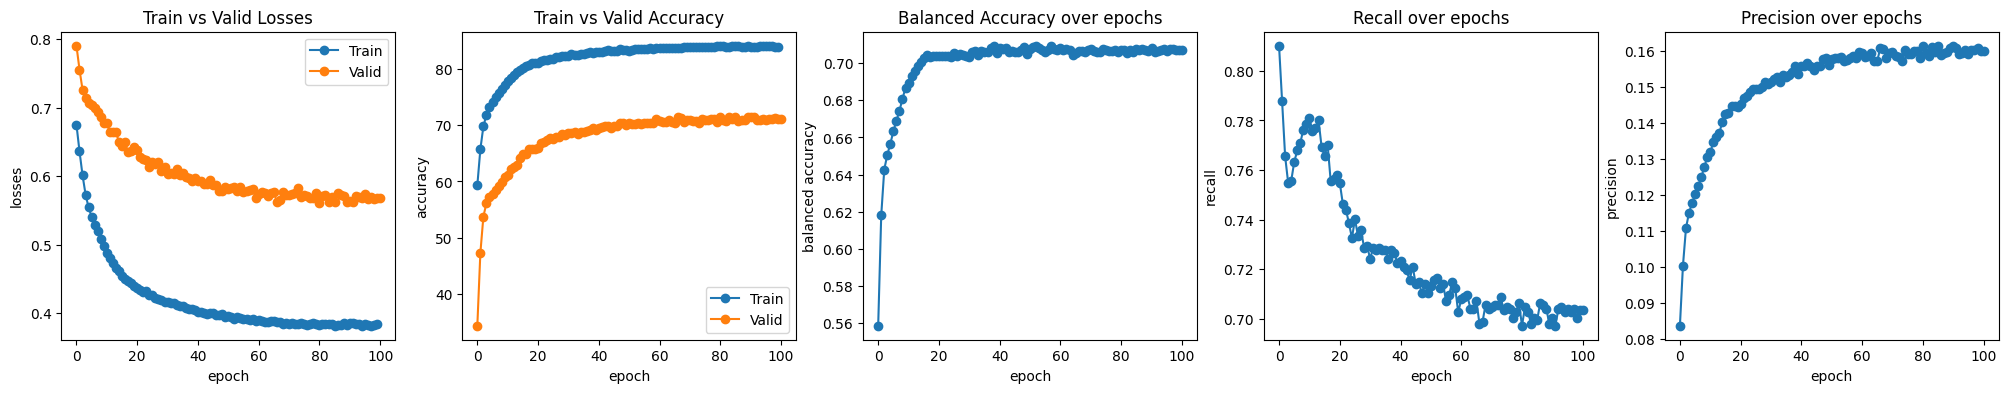

In [ ]:
# plot the loss and accuracy and
metrics = {
    'train_losses': train_losses,
    'train_accu': train_accu,
    'eval_losses': eval_losses,
    'eval_accu': eval_accu,
    'balance_accuracy_list': balance_accuracy_list,
    'precision_list': precision_list,
    'recall_list': recall_list
}
plot_metrics(metrics, ['loss', 'accuracy', 'balance_accuracy', 'recall', 'precision'])

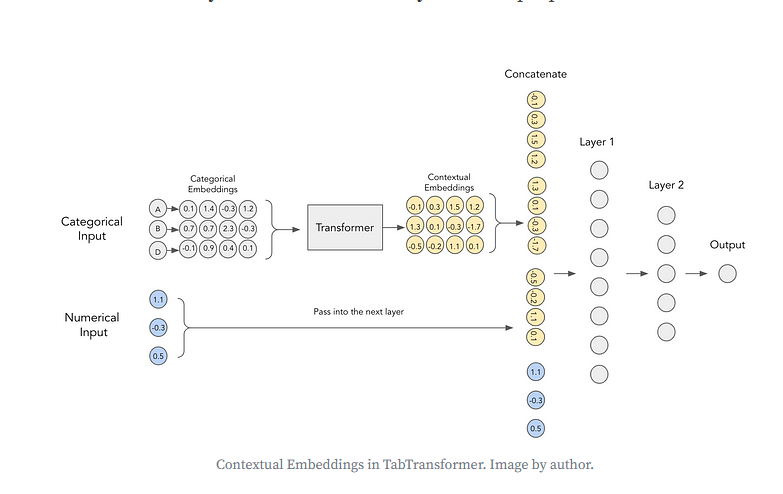

In [ ]:

#adaptive learning rate can have high variance in the early stages of training
Image(filename='data\Screenshot 2023-11-08 121716.png')

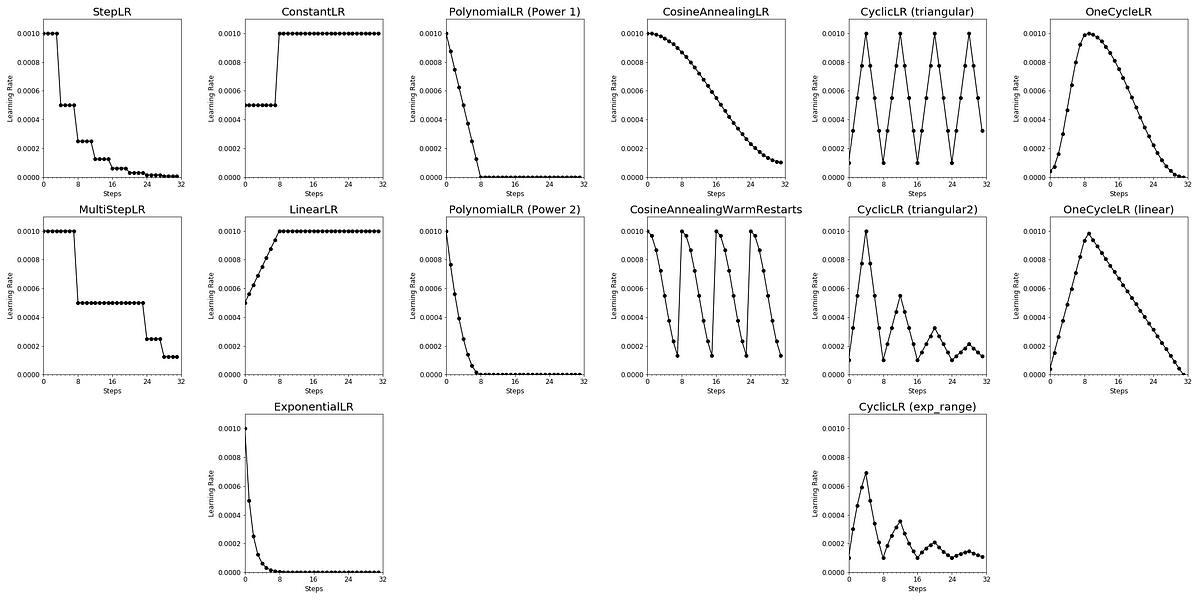

In [ ]:
Image(filename='data\qe6nYlH8zsmUdScyHMhRCQ-3509617497.png')

In [ ]:
accuracy, precision, recall, balance_accuracy = test_model('RCAST')

RuntimeError: Error(s) in loading state_dict for Net:
	Missing key(s) in state_dict: "fc3.weight", "fc3.bias", "fc4.weight", "fc4.bias", "fc5.weight", "fc5.bias", "fc6.weight", "fc6.bias", "fc7.weight", "fc7.bias", "batch_norm2.weight", "batch_norm2.bias", "batch_norm2.running_mean", "batch_norm2.running_var", "batch_norm3.weight", "batch_norm3.bias", "batch_norm3.running_mean", "batch_norm3.running_var", "batch_norm4.weight", "batch_norm4.bias", "batch_norm4.running_mean", "batch_norm4.running_var", "batch_norm5.weight", "batch_norm5.bias", "batch_norm5.running_mean", "batch_norm5.running_var", "batch_norm6.weight", "batch_norm6.bias", "batch_norm6.running_mean", "batch_norm6.running_var". 
	size mismatch for fc1.weight: copying a param with shape torch.Size([256, 43]) from checkpoint, the shape in current model is torch.Size([1024, 43]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([1, 256]) from checkpoint, the shape in current model is torch.Size([512, 1024]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for batch_norm1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for batch_norm1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for batch_norm1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for batch_norm1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).

In [ ]:
print('Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | Balance Accuracy: {balance_accuracy:.3f}')

Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | Balance Accuracy: {balance_accuracy:.3f}
